### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt, log

from acquire import acquire_data
from prepare import the_master_imputer, data_prep, percent_of_values_missing, change_data_to_int, change_data_to_object, zillow_single_unit_prop
from set_counties import create_county_cols
from summerize import summarize_data, show_distribution
from preprocessing import split_my_data, scale_data
from model import calculate_logerror

# Intro

## Jeremy & David
**Improving Zillow's Logerror**

### Agenda
    1. Summarize our findings verbally among our fellow data scientists 
    2. Go through our notebook and briefly summarize our thought process behind our ideas step-by-step
    3. present our conclusion and what our thoughts are behind solving zillow's zestimate that is wildly broken

### Summary

- In the zillow dataset log error comes from this equation 
> **logerror = log(prediction) - log(actual)**  [Source](https://www.kaggle.com/c/zillow-prize-1/overview/evaluation)
- Our goal was to use different clusters and even some vanilla features in a regression models to beat the already established baseline that is zillow's logerror presented in this dataset
- we used these techniques to predict our own zestimate and then ran that as our prediction variable in the logerror algorithm to equate our own logerror that would be better than the baseline 
- We failed to accomplish our goal, we couldn't find the right features to create a logerror that would beat the zillow baseline logerror.



# Acquire

- using our function from our acquire.py file to import our data from SQL and import it into a csv, drop the Unnamed column and assign it to a data frame
- in our SQL query we decided to eliminate all properties that were not a single unit family residential home
- we also cut some of our outliers by removing any home where their structuretaxvaluedollarcnt was > $1,000,000

In [2]:
df = acquire_data()

Acquiring data ...

- csv already exist

Data has been acquired


# Prepare

**more outlier control**

- this function below, limits our result's to include homes where the unit's square footage is no less than 500 sq ft, and no less than 1 bedroom and 1 bathroom 

In [3]:
df = zillow_single_unit_prop(df)

- our data_prep function removes any column missing 50% or more of their data as well as any row missing up to 75% of it's data (*We didn't want to waste time strategizing ways to accuratly sum up data missing over 50% of it's values*) 

In [4]:
df = data_prep(df)

- the function below tells us what percent of each column is missing

In [5]:
percent_of_values_missing(df)

parcelid                        0.00
logerror                        0.00
transactiondate                 0.00
bathroomcnt                     0.00
bedroomcnt                      0.00
calculatedfinishedsquarefeet    0.00
fips                            0.00
latitude                        0.00
longitude                       0.00
lotsizesquarefeet               0.60
regionidcity                    1.93
regionidcounty                  0.00
regionidzip                     0.04
yearbuilt                       0.06
structuretaxvaluedollarcnt      0.00
taxvaluedollarcnt               0.00
landtaxvaluedollarcnt           0.00
taxamount                       0.01
dtype: float64

- using the_master_imputer function, we will fill all of our missing functions with the median value, for that column's rows (*Since we weren't missing more than 2% of any data, we felt that the median would suffice for the missing values in our dataset*)

In [6]:
df = the_master_imputer(df)

We see that all of our missing values are taken care of

In [7]:
df.isna().sum()

parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
dtype: int64

>now we're going to take our fips # and use that to impute what county our observations were made in using our create_county_cols function and in the process we're going to drop our fips & our regioncounty columns.
fips source: [THIS LINK](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697)

In [8]:
df = create_county_cols(df)

In [9]:
df['bed_bath_ratio'] = df['bathroomcnt'] / df['bedroomcnt']

df['age'] = 2017 - df['yearbuilt']

df['tax_rate'] = df['taxamount'] / df['taxvaluedollarcnt']

### Lets change our values so we can have less noise in our exploration / modeling phase

- using our change_data_to_object function to change the datatypes of *parcelid*, *regionidcity*, *regionidcounty*, *fips* & *regionidzip* to object. (we dont want to do any addition with our unit id's)

In [10]:
cols = ['parcelid', 'regionidzip', 'regionidcity', 'LA', 'Ventura', 'Orange', 'fips', 'regionidcounty']
df = change_data_to_object(df, cols)

- using our change_data_to_int function to change the datatypes of *yearbuilt*, *latitude*, *longitude*, *lotsizesquarefeet*, *calculatedfinishedsquarefeet*, & *bedroomcnt* to change these datatypes from float's to integers to make the data more exclusive

In [11]:
cols = ['yearbuilt', 'latitude', 'longitude', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt' ]
df = change_data_to_int(df, cols)

### We're going summarize what our data looks like
- this functions runs a .info, a .describe and a .shape on our data and returns it in a pandas series

In [12]:
summarize_data(df)

******** Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50588 entries, 0 to 51585
Data columns (total 25 columns):
logerror                        50588 non-null float64
transactiondate                 50588 non-null object
bathroomcnt                     50588 non-null float64
structuretaxvaluedollarcnt      50588 non-null float64
taxvaluedollarcnt               50588 non-null float64
landtaxvaluedollarcnt           50588 non-null float64
taxamount                       50588 non-null float64
county                          50588 non-null object
bed_bath_ratio                  50588 non-null float64
age                             50588 non-null float64
tax_rate                        50588 non-null float64
parcelid                        50588 non-null object
regionidzip                     50588 non-null object
regionidcity                    50588 non-null object
LA                              50588 non-null object
Ventura                         50588 non-null object
Oran

In [13]:
df.describe()

,logerror,bathroomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,bed_bath_ratio,age,tax_rate,yearbuilt,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt
count,50588.000000,50588.000000,50588.000000,5.058800e+04,5.058800e+04,50588.000000,50588.000000,50588.000000,50588.000000,50588.000000,5.058800e+04,5.058800e+04,5.058800e+04,50588.000000,50588.000000
mean,0.017393,2.226249,171563.618111,4.666676e+05,2.951040e+05,5719.902954,0.691002,53.988080,0.013378,1963.011920,3.402361e+07,-1.181923e+08,1.080494e+04,1839.313197,3.251265
std,0.171774,0.875288,145742.817192,4.427577e+05,3.466417e+05,5096.031666,0.227583,22.744205,0.005665,22.744205,2.747764e+05,3.563559e+05,8.739212e+04,807.672060,0.849326
min,-4.655420,1.000000,148.000000,3.254000e+03,1.610000e+02,49.180000,0.200000,1.000000,0.000157,1878.000000,3.334062e+07,-1.194754e+08,2.360000e+02,501.000000,1.000000
25%,-0.024679,2.000000,75978.000000,1.894995e+05,7.281550e+04,2610.730000,0.500000,39.000000,0.011658,1950.000000,3.382712e+07,-1.183960e+08,5.554000e+03,1260.000000,3.000000
50%,0.006541,2.000000,128668.500000,3.650000e+05,2.121285e+05,4549.820000,0.666667,57.000000,0.012347,1960.000000,3.402031e+07,-1.181497e+08,6.774000e+03,1635.000000,3.000000
75%,0.039322,3.000000,215701.000000,5.941638e+05,3.936885e+05,7096.497500,0.750000,67.000000,0.013737,1978.000000,3.418934e+07,-1.179295e+08,8.556000e+03,2233.000000,4.000000
max,3.394544,5.500000,999140.000000,1.087391e+07,1.054104e+07,129365.370000,3.000000,139.000000,0.493647,2016.000000,3.481877e+07,-1.175546e+08,6.971010e+06,7356.000000,5.000000


## Preprocessing

- using split_my_data function to split our data into train, test and validate data frames

In [14]:
train, test, val = split_my_data(df, .15, .50)

In [15]:
train_scaled = train[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
train_scaled, scaler = scale_data(train_scaled)
train[['scaled_structuretaxvaluedollarcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_bedroomcnt']] = train_scaled[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
    
test_scaled = test[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
test_scaled, scaler = scale_data(test_scaled)
test[['scaled_structuretaxvaluedollarcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_bedroomcnt']] = test_scaled[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
    

val_scaled = val[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
val_scaled, scaler = scale_data(val_scaled)
val[['scaled_structuretaxvaluedollarcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_bedroomcnt']] = val_scaled[['structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt']]
    





# Exploration

- Perform clustering with logerror, longitude & latitude

In [16]:
X = train[['logerror', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['log_cluster'] = kmeans.predict(X)

In [17]:
X = test[['logerror', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

test['log_cluster'] = kmeans.predict(X)

In [18]:
X = val[['logerror', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

val['log_cluster'] = kmeans.predict(X)

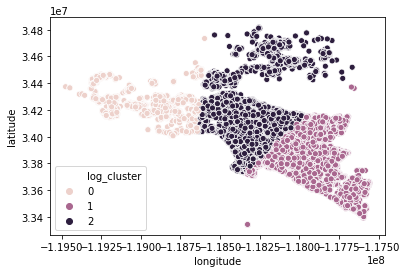

In [19]:
sns.scatterplot(x='longitude', y='latitude' , hue='log_cluster', data=train)

- 3 distinct clusters of areas found using longitude and latitude
- lets find out if they're correlated with our counties by visualizing our longitude, latitude and hue it by county

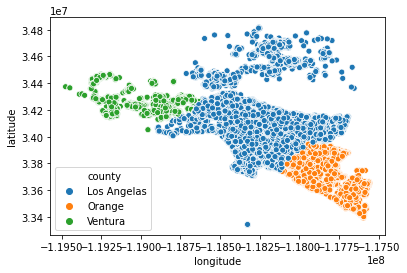

In [20]:
sns.scatterplot('longitude', 'latitude', hue='county', data=train)

- visually looks incredibly similar.
- tells us that their logerror algorithm is dependent on where a home is located 

In [21]:
train.head()

,logerror,transactiondate,bathroomcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,county,bed_bath_ratio,age,...,yearbuilt,latitude,longitude,lotsizesquarefeet,calculatedfinishedsquarefeet,bedroomcnt,scaled_structuretaxvaluedollarcnt,scaled_calculatedfinishedsquarefeet,scaled_bedroomcnt,log_cluster
3147,0.041543,2017-01-23,2.0,87770.0,206357.0,118587.0,2613.64,Los Angelas,0.666667,56.0,...,1961,34294703,-118503402,11098,1040,3,0.087710,0.078629,0.50,2
9831,-0.086821,2017-03-07,1.0,188308.0,689727.0,501419.0,8364.83,Los Angelas,0.500000,71.0,...,1946,34037635,-118430006,6596,1340,2,0.188350,0.122392,0.25,2
37321,0.037711,2017-07-11,2.0,111383.0,624378.0,512995.0,7127.86,Orange,0.666667,45.0,...,1972,33799154,-118024250,5042,1556,3,0.111347,0.153902,0.50,1
41583,0.019999,2017-07-31,3.0,346163.0,679000.0,332837.0,8177.80,Orange,0.750000,11.0,...,2006,33802466,-117970613,3710,2401,4,0.346364,0.277170,0.75,1
32287,0.026711,2017-06-20,2.5,411840.0,705531.0,293691.0,12994.50,Orange,0.625000,8.0,...,2009,33713991,-117817524,3042,2484,4,0.412107,0.289278,0.75,1


In [22]:
X = train[['logerror','scaled_calculatedfinishedsquarefeet' ]]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

In [23]:
X = test[['logerror','scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

test['sqft_cluster'] = kmeans.predict(X)

In [24]:
X = val[['logerror','scaled_calculatedfinishedsquarefeet' ]]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

val['sqft_cluster'] = kmeans.predict(X)

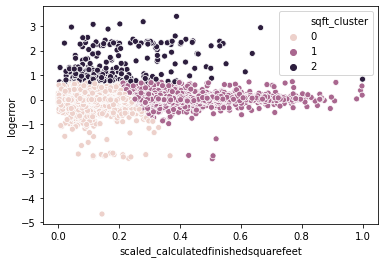

In [25]:
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

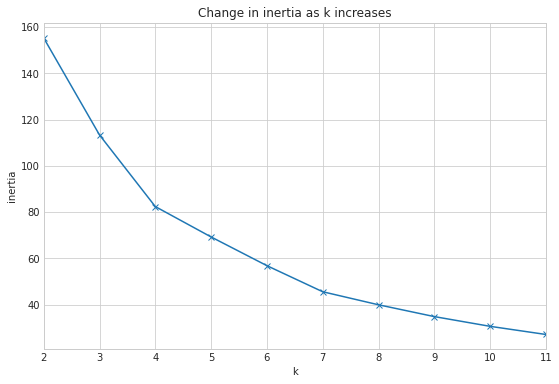

In [26]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- looks like the optimal k value would be about 5

In [27]:
X = train[['logerror', 'scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

In [28]:
X = test[['logerror', 'scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

test['sqft_cluster'] = kmeans.predict(X)

In [29]:
X = val[['logerror', 'scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

val['sqft_cluster'] = kmeans.predict(X)

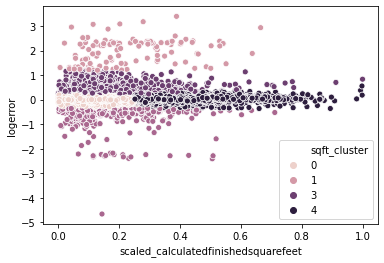

In [30]:
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

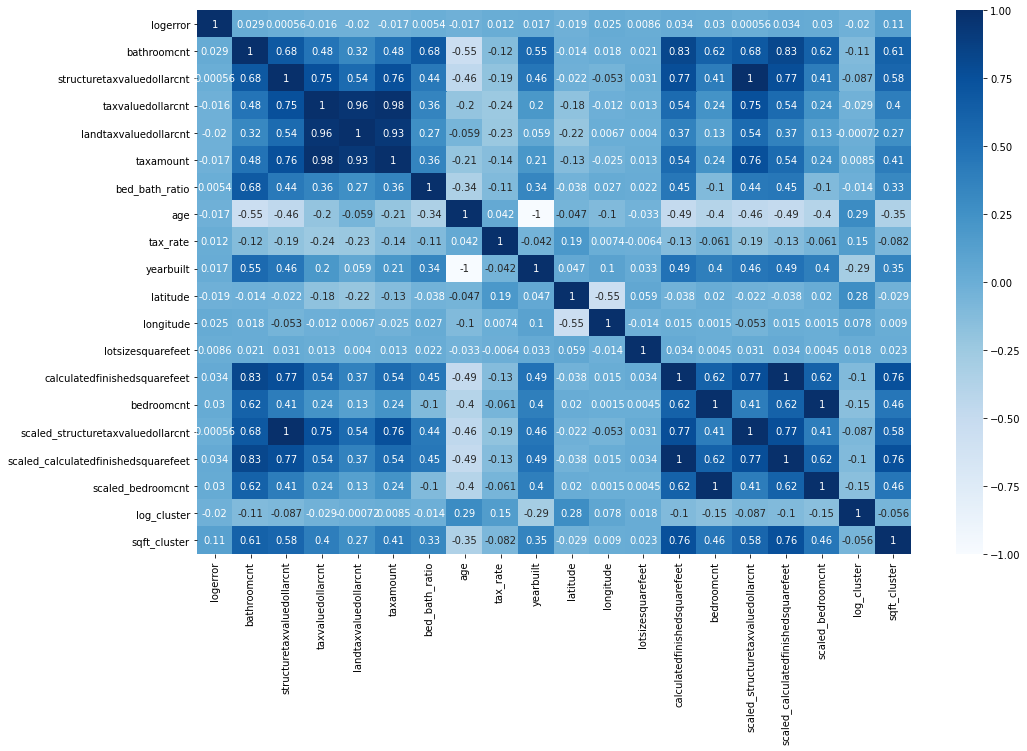

In [31]:
# Overall correlation of the features and the target.
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [32]:
X = train[['logerror', 'scaled_structuretaxvaluedollarcnt', 'scaled_bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['bath_money_cluster'] = kmeans.predict(X)

In [33]:
X = test[['logerror', 'scaled_structuretaxvaluedollarcnt', 'scaled_bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

test['bath_money_cluster'] = kmeans.predict(X)

In [34]:
X = val[['logerror', 'scaled_structuretaxvaluedollarcnt', 'scaled_bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

val['bath_money_cluster'] = kmeans.predict(X)

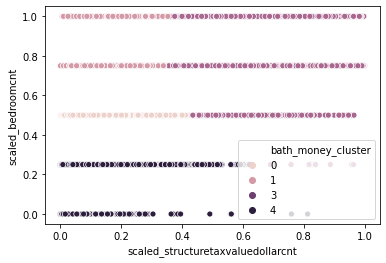

In [35]:
sns.scatterplot(x='scaled_structuretaxvaluedollarcnt', y='scaled_bedroomcnt', hue='bath_money_cluster', data=train)

# Modeling

- We used a *linear regression*, and *polynomial regression* algorithms to predict logerror

- The data used have been all of our features and specified clusters

#### step 1 encode the county column

In [36]:
# run this function
def encode(train, test, col_name):
    from sklearn.preprocessing import LabelEncoder
    
    # Integer Encoding
    int_encoder = LabelEncoder()
    train[col_name] = int_encoder.fit_transform(train[col_name])
    test[col_name] = int_encoder.transform(test[col_name])
    
    return train, test

In [37]:
train, val = encode(train, val, 'county')

#### step 2 split our train and validate data sets in X_train,and X_val's

In [38]:
X_train = train[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet', 'age', 'tax_rate']]
y_train = train[['taxvaluedollarcnt']]
X_val = val[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet', 'age', 'tax_rate']]
y_val = val[['taxvaluedollarcnt']]

#### step 3 create the baseline model

In [39]:
predictions = pd.DataFrame()
predictions['actual'] = y_train['taxvaluedollarcnt']

predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

In [40]:
predictions.head()

,actual,baseline
3147,206357.0,468000.126863
9831,689727.0,468000.126863
37321,624378.0,468000.126863
41583,679000.0,468000.126863
32287,705531.0,468000.126863


#### step 

In [41]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

#### step 5 evaluate the model

In [42]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

>add our predictions to our predictions data frame

In [43]:
predictions['prediction'] = y_train_pred

predictions.head()

,actual,baseline,prediction
3147,206357.0,468000.126863,251130.720984
9831,689727.0,468000.126863,371642.279473
37321,624378.0,468000.126863,402210.106460
41583,679000.0,468000.126863,572439.418607
32287,705531.0,468000.126863,450208.204523


#### Outcome of the linear regression model

In [44]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 356561.39006758324
R2 of training set is 0.3510308447939424
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 365416.4834417069
R2 of validation set is 0.29841923317964114


In [45]:
lm_df = calculate_logerror('actual', 'prediction', predictions)

In [46]:
lm_df['zillow_logerror'] = train['logerror']

lm_df['mae_sum'] = abs(lm_df['zillow_logerror'] - lm_df['logerror'])

lm_df['mae'] = lm_df['mae_sum'] / len(lm_df['zillow_logerror'])

In [47]:
lm_df.head()

,actual,baseline,prediction,logerror,zillow_logerror,mae_sum,mae
3147,12.237363,468000.126863,12.433729,0.196366,0.041543,0.154822,0.000004
9831,13.444051,468000.126863,12.825687,-0.618364,-0.086821,0.531543,0.000012
37321,13.344511,468000.126863,12.904730,-0.439781,0.037711,0.477493,0.000011
41583,13.428376,468000.126863,13.257662,-0.170714,0.019999,0.190713,0.000004
32287,13.466706,468000.126863,13.017465,-0.449241,0.026711,0.475951,0.000011


#### now we plot our model

### model by county

In [48]:
la_train = train[train.LA == 1]
orange_train = train[train.Orange == 1]
ventura_train = train[train.Ventura == 1]

la_test = test[test.LA == 1]
orange_test = test[test.Orange == 1]
ventura_test = test[test.Ventura == 1]

la_val = val[val.LA == 1]
orange_val = val[val.Orange == 1]
ventura_val = val[val.Ventura == 1]

#### LA model

In [49]:
X_train = la_train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = la_train[['taxvaluedollarcnt']]
X_val = la_val[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = la_val[['taxvaluedollarcnt']]

In [50]:
la_predictions = pd.DataFrame()
la_predictions['actual'] = y_train['taxvaluedollarcnt']

la_predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

In [51]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

In [52]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

In [53]:
la_predictions['prediction'] = y_train_pred

la_predictions.head()

,actual,baseline,prediction
3147,206357.0,427855.810469,240509.993960
9831,689727.0,427855.810469,354467.184489
48467,168000.0,427855.810469,242731.170748
38338,1367090.0,427855.810469,796329.914921
24946,816000.0,427855.810469,457895.073205


In [54]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 377157.2255889316
R2 of training set is 0.26082892031865224
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 346055.6109408906
R2 of validation set is 0.27761976162229196


In [55]:
la_lm = calculate_logerror('actual', 'prediction', la_predictions)

In [56]:
la_lm['zillow_logerror'] = la_train['logerror']

la_lm['mae_sum'] = abs(la_lm['zillow_logerror'] - la_lm['logerror'])

la_lm['mae'] = la_lm['mae_sum'] / len(la_lm['zillow_logerror'])

In [57]:
la_lm.head()

,actual,baseline,prediction,logerror,zillow_logerror,mae_sum,mae
3147,12.237363,427855.810469,12.390517,0.153154,0.041543,0.111610,0.000004
9831,13.444051,427855.810469,12.778371,-0.665680,-0.086821,0.578859,0.000021
48467,12.031719,427855.810469,12.399710,0.367991,-0.068252,0.436242,0.000016
38338,14.128195,427855.810469,13.587769,-0.540426,-0.485174,0.055252,0.000002
24946,13.612170,427855.810469,13.034395,-0.577774,0.021081,0.598855,0.000022


#### now we plot our la model

#### Ventura model

In [58]:
X_train = ventura_train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = ventura_train[['taxvaluedollarcnt']]
X_val = ventura_val[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = ventura_val[['taxvaluedollarcnt']]

In [59]:
ven_predictions = pd.DataFrame()
ven_predictions['actual'] = y_train['taxvaluedollarcnt']

ven_predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

In [60]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

In [61]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

In [62]:
ven_predictions['prediction'] = y_train_pred

ven_predictions.head()

,actual,baseline,prediction
48066,874000.0,490832.946829,669330.000359
38198,454438.0,490832.946829,377885.758109
48781,473000.0,490832.946829,304988.494521
8750,660000.0,490832.946829,495206.678916
40307,263516.0,490832.946829,274014.797801


In [63]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 220269.40145240093
R2 of training set is 0.5428436463185909
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 205234.0799548425
R2 of validation set is 0.5094177568601064


In [64]:
ven_lm = calculate_logerror('actual', 'prediction', ven_predictions)

In [65]:
ven_lm['zillow_logerror'] = ventura_train['logerror']

ven_lm['mae_sum'] = abs(ven_lm['zillow_logerror'] - ven_lm['logerror'])

ven_lm['mae'] = ven_lm['mae_sum'] / len(ven_lm['zillow_logerror'])

In [78]:
ven_lm.head()

,actual,baseline,prediction,logerror,zillow_logerror,mae_sum,mae
48066,13.680836,490832.946829,13.414032,-0.266803,0.015589,0.282392,0.000078
38198,13.026817,490832.946829,12.842347,-0.184470,-0.046028,0.138441,0.000038
48781,13.066851,490832.946829,12.628029,-0.438821,0.019120,0.457941,0.000127
8750,13.399995,490832.946829,13.112730,-0.287265,0.187863,0.475128,0.000132
40307,12.481869,490832.946829,12.520937,0.039068,-0.045564,0.084632,0.000023


### now we plot our ventura county model

#### Orange county model

In [67]:
X_train = orange_train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = orange_train[['taxvaluedollarcnt']]
X_val = orange_val[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = orange_val[['taxvaluedollarcnt']]

In [68]:
or_predictions = pd.DataFrame()
or_predictions['actual'] = y_train['taxvaluedollarcnt']

or_predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

In [69]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

In [70]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

In [71]:
or_predictions['prediction'] = y_train_pred

or_predictions.head()

,actual,baseline,prediction
37321,624378.0,556725.545744,4.022867e+05
41583,679000.0,556725.545744,6.665014e+05
32287,705531.0,556725.545744,6.409553e+05
23313,536061.0,556725.545744,1.037545e+06
40735,548235.0,556725.545744,2.704501e+05


In [72]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 369442.9470454493
R2 of training set is 0.38005630001314716
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 430190.9033805385
R2 of validation set is 0.31507278817651885


In [73]:
or_lm = calculate_logerror('actual', 'prediction', or_predictions)

In [74]:
or_lm['zillow_logerror'] = orange_train['logerror']

or_lm['mae_sum'] = abs(or_lm['zillow_logerror'] - or_lm['logerror'])

or_lm['mae'] = or_lm['mae_sum'] / len(or_lm['zillow_logerror'])

In [75]:
or_lm.head()

,actual,baseline,prediction,logerror,zillow_logerror,mae_sum,mae
37321,13.344511,556725.545744,12.904920,-0.439591,0.037711,0.477302,0.000041
41583,13.428376,556725.545744,13.409797,-0.018579,0.019999,0.038578,0.000003
32287,13.466706,556725.545744,13.370715,-0.095991,0.026711,0.122702,0.000011
23313,13.192003,556725.545744,13.852368,0.660365,0.043652,0.616713,0.000053
40735,13.214459,556725.545744,12.507843,-0.706616,0.020092,0.726709,0.000062


#### now we plot our orange county model

### conclusions

- 

# Recommendations